# Connection to drive and path definition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/final/SANDS')
path_files ='/content/drive/MyDrive/Colab Notebooks/final/UC3'

# Import libraries

In [ ]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
import time
from calendar import timegm, monthrange
from datetime import datetime, timedelta
import math
import sands
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from os import listdir
from os.path import isfile, join
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import CategoricalAccuracy,Accuracy,BinaryAccuracy


from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet

# Data generation

Run the next four cells if you want to generate new data. Otherwise skip them and load the saved data file

In [ ]:
parameters1 = {
        'time_delta':5
    }

In [ ]:
device_filter = {
    'vendor':'Versa'
}

In [ ]:
metric_df = sands.generate_device_metric_time_range(datetime.now(),datetime.now()+timedelta(minutes=4),parameters1,"none",['mem_utilization','cpu_utilization'],device_filter)


In [ ]:
metric_df.to_csv(join(path_files,'mem_and_cpu_utilization_sdwan_metric.csv'))

Run the next cell to load saved dataset

In [ ]:
metric_df=pd.read_csv(join(path_files,'mem_and_cpu_utilization_sdwan_metric.csv'),index_col=0)

In [ ]:
metric_df

,timestamp,cpu_utilization,device_name,vendor,model,os,version,hw_revision,role,ip_address,mem_utilization
0,1668179980,NaN,E-1-1,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_hub,10.3.1.1,31.0
1,1668179980,32.0,E-1-1,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_hub,10.3.1.1,NaN
2,1668179980,NaN,E-1-2,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_hub,10.3.1.2,30.0
3,1668179980,33.0,E-1-2,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_hub,10.3.1.2,NaN
4,1668179980,NaN,E-2-1,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_branch,10.3.2.1,31.0
...,...,...,...,...,...,...,...,...,...,...,...
395,1668179980,11.0,E-99-2,Versa,versa_2,VOS,21.1.1,hw-versa-0001,vedge_branch,10.3.99.2,NaN
396,1668179980,NaN,E-100-1,Versa,versa_2,VOS,21.1.0,hw-versa-0002,vedge_hub,10.3.100.1,75.0
397,1668179980,34.0,E-100-1,Versa,versa_2,VOS,21.1.0,hw-versa-0002,vedge_hub,10.3.100.1,NaN
398,1668179980,NaN,E-100-2,Versa,versa_2,VOS,21.1.0,hw-versa-0002,vedge_hub,10.3.100.2,77.0


# Data preparation

In [ ]:
metric_df = metric_df.fillna(0)

In [ ]:
metric_df

,timestamp,cpu_utilization,device_name,vendor,model,os,version,hw_revision,role,ip_address,mem_utilization
0,1668179980,0.0,E-1-1,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_hub,10.3.1.1,31.0
1,1668179980,32.0,E-1-1,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_hub,10.3.1.1,0.0
2,1668179980,0.0,E-1-2,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_hub,10.3.1.2,30.0
3,1668179980,33.0,E-1-2,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_hub,10.3.1.2,0.0
4,1668179980,0.0,E-2-1,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_branch,10.3.2.1,31.0
...,...,...,...,...,...,...,...,...,...,...,...
395,1668179980,11.0,E-99-2,Versa,versa_2,VOS,21.1.1,hw-versa-0001,vedge_branch,10.3.99.2,0.0
396,1668179980,0.0,E-100-1,Versa,versa_2,VOS,21.1.0,hw-versa-0002,vedge_hub,10.3.100.1,75.0
397,1668179980,34.0,E-100-1,Versa,versa_2,VOS,21.1.0,hw-versa-0002,vedge_hub,10.3.100.1,0.0
398,1668179980,0.0,E-100-2,Versa,versa_2,VOS,21.1.0,hw-versa-0002,vedge_hub,10.3.100.2,77.0


In [ ]:
new_metric_df = metric_df.groupby('device_name').sum(['cpu_utilization','memory_utilization'])

In [ ]:
new_metric_df

,timestamp,cpu_utilization,mem_utilization
device_name,,,
E-1-1,3336359960,32.0,31.0
E-1-2,3336359960,33.0,30.0
E-10-1,3336359960,32.0,32.0
E-10-2,3336359960,30.0,31.0
E-100-1,3336359960,34.0,75.0
...,...,...,...
E-97-2,3336359960,81.0,31.0
E-98-1,3336359960,11.0,32.0
E-98-2,3336359960,11.0,33.0


In [ ]:
new_metric_df.drop(columns=['timestamp'],inplace=True)

In [ ]:
new_metric_df

,cpu_utilization,mem_utilization
device_name,,
E-1-1,32.0,31.0
E-1-2,33.0,30.0
E-10-1,32.0,32.0
E-10-2,30.0,31.0
E-100-1,34.0,75.0
...,...,...
E-97-2,81.0,31.0
E-98-1,11.0,32.0
E-98-2,11.0,33.0


timestamp is not relevant in this use case, we will focus on the memory utilization column, and the device_name columns. All other columns will be ignored for the moment.

Text(0.5, 1.0, 'Memory utilization in SD-WAN devices')

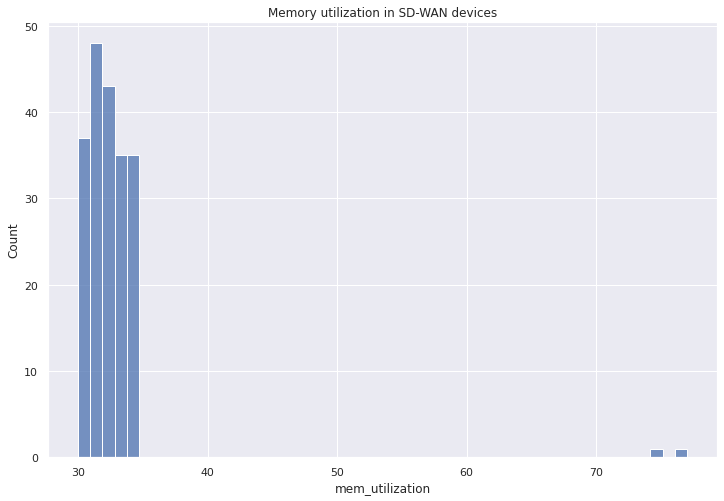

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(data=new_metric_df,x='mem_utilization', bins=50)
plt.title('Memory utilization in SD-WAN devices')

Text(0, 0.5, '% utilization')

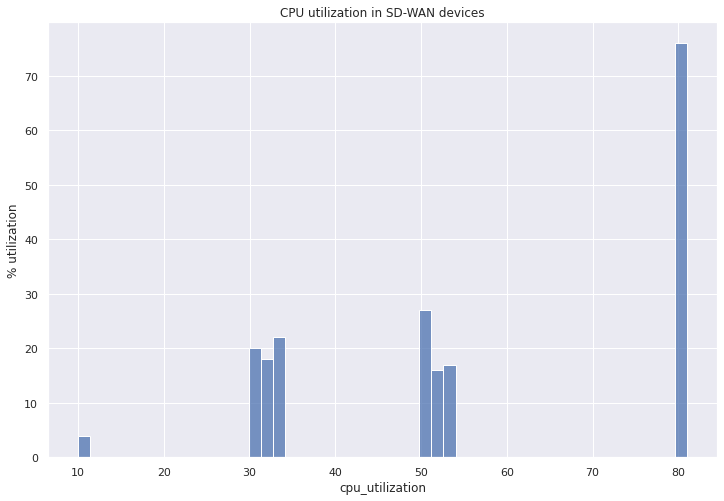

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(data=new_metric_df,x='cpu_utilization', bins=50)
plt.title('CPU utilization in SD-WAN devices')
plt.ylabel('% utilization')

Text(0, 0.5, '% utilization')

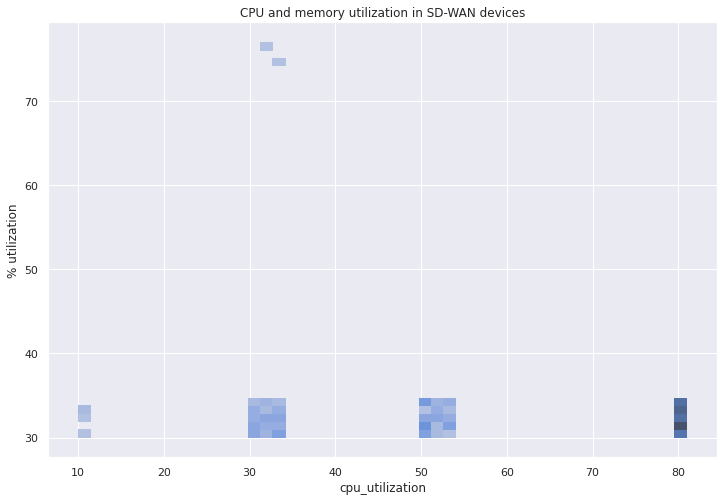

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(data=new_metric_df,x='cpu_utilization', y='mem_utilization', bins=50)
plt.title('CPU and memory utilization in SD-WAN devices')
plt.ylabel('% utilization')

Text(0.5, 1.0, 'CPU and memory utilization in SD-WAN devices')

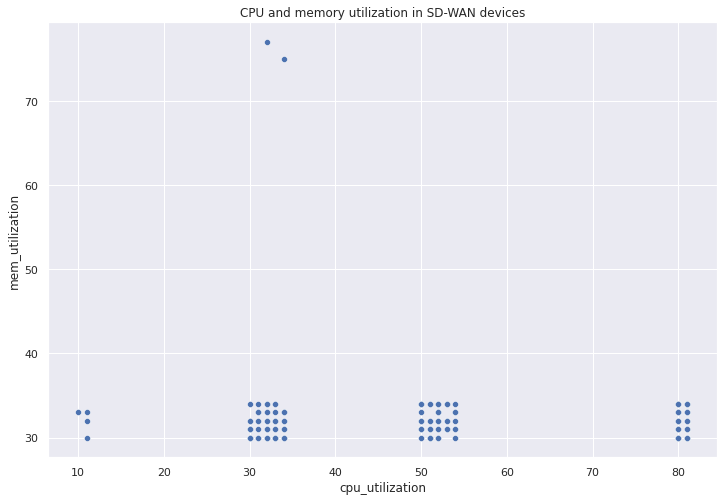

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.scatterplot(data=new_metric_df,x='cpu_utilization', y='mem_utilization')
plt.title('CPU and memory utilization in SD-WAN devices')


In [ ]:
X_train = new_metric_df[['mem_utilization','cpu_utilization']].values
X_test = X_train

In [ ]:
X_train.shape

(200, 2)

# DBSCAN

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)

In [ ]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_train_scaled)
distances, indices = nbrs.kneighbors(X_train_scaled)

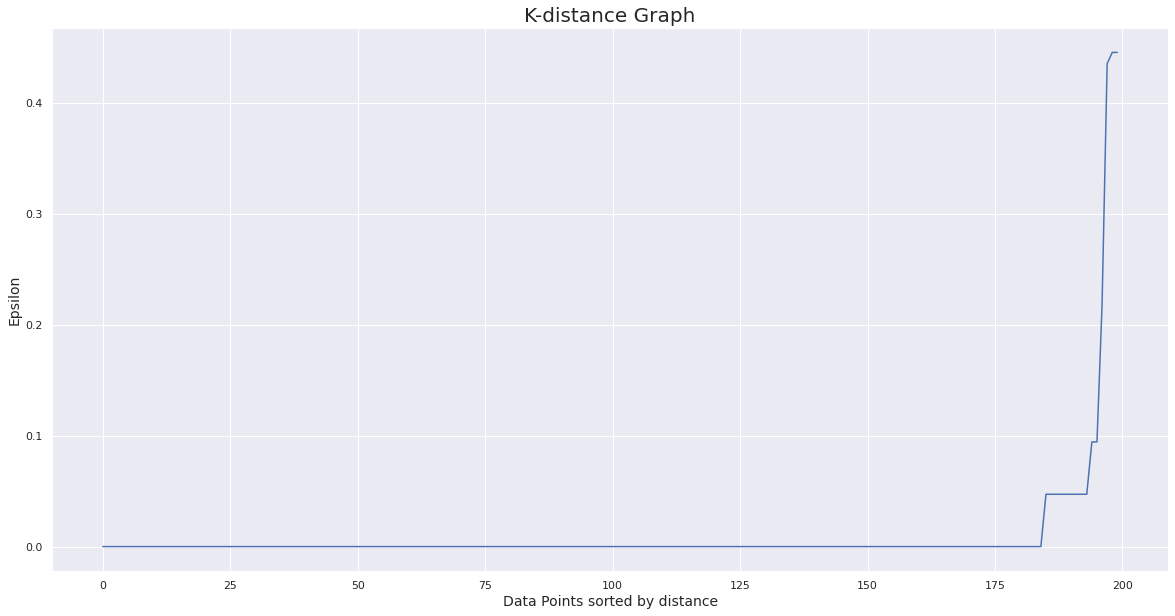

In [ ]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [ ]:
dbscan=DBSCAN(eps=2,min_samples=10)
dbscan.fit(X_train)

DBSCAN(eps=2, min_samples=10)

In [ ]:
dbscan.labels_

array([ 0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0,  0,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  0,  0,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  0,  0,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2, -1, -1, -1, -1])

Text(0.5, 1.0, 'CPU and memory utilization clusters with DBSCAN in SD-WAN devices')

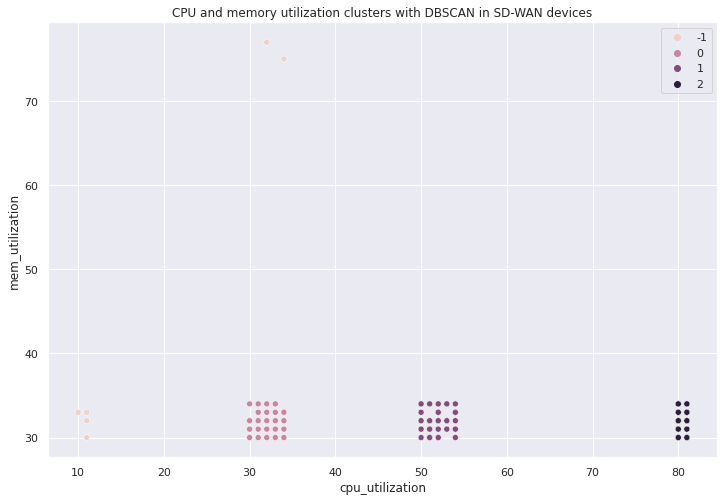

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.scatterplot(data=new_metric_df,x='cpu_utilization', y='mem_utilization',hue=dbscan.labels_)
plt.title('CPU and memory utilization clusters with DBSCAN in SD-WAN devices')

# K-Means

In [ ]:
wss = []
for i in range(1,11):
  kmeans = KMeans(n_clusters=i,init="k-means++",random_state=42)
  kmeans.fit(X_train)
  wss.append(kmeans.inertia_)


Text(0.5, 1.0, 'Elbow method to select K number of clusters')

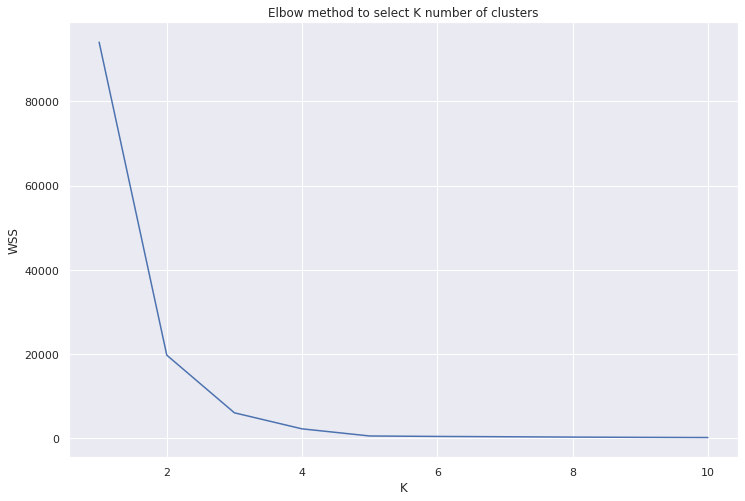

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x = range(1,11), y = wss)
plt.ylabel('WSS')
plt.xlabel('K')
plt.title('Elbow method to select K number of clusters')

In [ ]:
K = 3

In [ ]:
KMeans_model = KMeans(n_clusters=K,init="k-means++",random_state=42)
KMeans_clusters = KMeans_model.fit_predict(X_train)
new_metric_df['cluster']=KMeans_clusters

Text(0.5, 1.0, 'CPU and memory utilization clusters with K-means in SD-WAN devices')

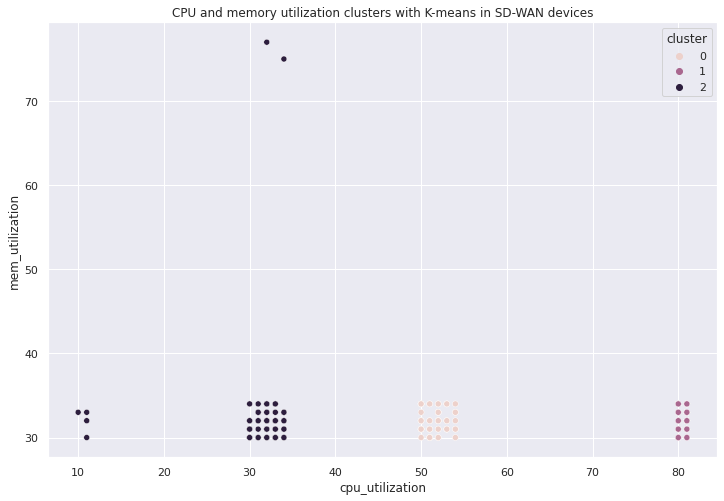

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.scatterplot(data=new_metric_df,x='cpu_utilization', y='mem_utilization',hue='cluster')
plt.title('CPU and memory utilization clusters with K-means in SD-WAN devices')

# Hierarchical Clustering

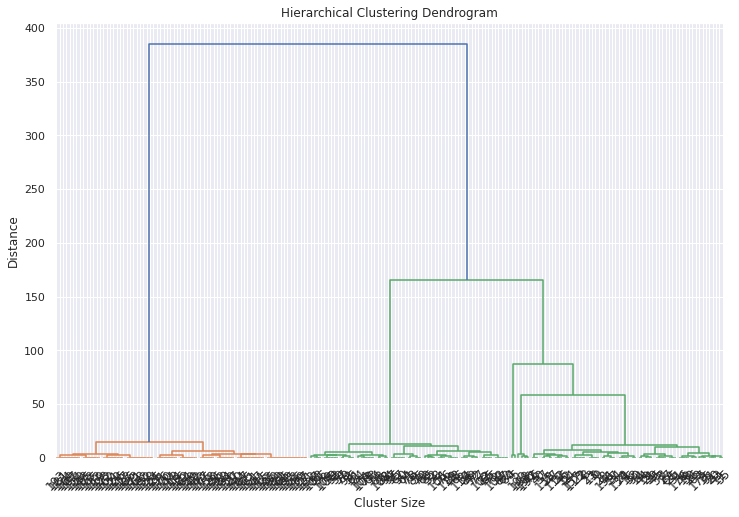

In [ ]:
Z=linkage(X_train,'ward')

# Plotting Dendogram
dendrogram(Z, leaf_rotation=45., leaf_font_size=12.)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.rcParams["figure.figsize"] = (14,6)
plt.show()

In [ ]:
K=3

In [ ]:
model_hcluster = AgglomerativeClustering(n_clusters=K,affinity='euclidean',linkage='ward')
model_hcluster.fit(X_train)

AgglomerativeClustering(n_clusters=3)

In [ ]:
new_metric_df['hcluster']=model_hcluster.labels_

Text(0.5, 1.0, 'CPU and memory utilization clusters with Agglomerative Hierarchical Clustering in SD-WAN devices')

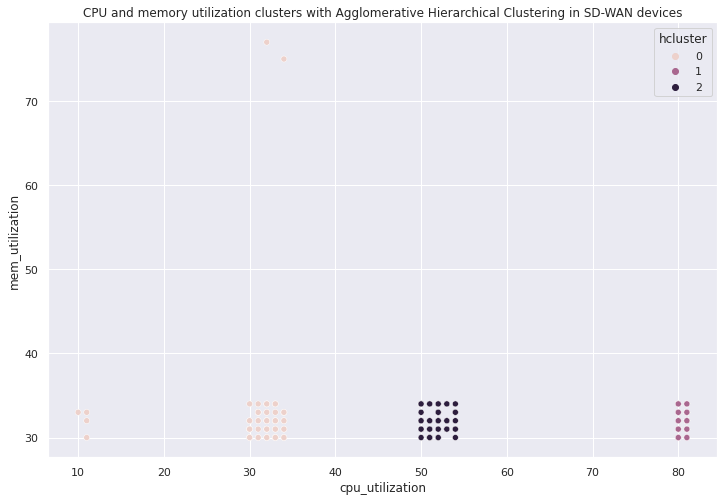

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.scatterplot(data=new_metric_df,x='cpu_utilization', y='mem_utilization',hue='hcluster')
plt.title('CPU and memory utilization clusters with Agglomerative Hierarchical Clustering in SD-WAN devices')